# Bayesian Logistic Regression with PyMC3

In this notebook we will be using pymc3 to examine posterior probability distributions for the parameters in logistic regression for classification.

We start by importing our required libraries.

In [1]:
# This is a simple example of using pymc3 for Bayesian inference of the parameter distribution.
# written by William F Basener
# University of Virginia

import pymc3 as pm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print(pm.__version__)

3.8


We define a function that will be helpful for plotting.  This function does little mathematically, but will give us very nice trace plots.

In [3]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

Load the data and look a the data frame.

In [4]:
data = pd.read_csv('../input/iris-flower-dataset/IRIS.csv')
data = data[['sepal_length','sepal_width','petal_length','petal_width','species']]
print(np.unique(data['species']))
data.describe()


['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
data.loc[data['species'] == 'Iris-setosa',:].mean()*10

sepal_length    50.06
sepal_width     34.18
petal_length    14.64
petal_width      2.44
dtype: float64

In [6]:
data.loc[data['species'] == 'Iris-setosa',:].cov()*10

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.242490,1.002980,0.161388,0.105469
sepal_width,1.002980,1.451796,0.116816,0.114367
petal_length,0.161388,0.116816,0.301061,0.056980
petal_width,0.105469,0.114367,0.056980,0.114939


We are using the seaborn plottng library.  This enables a very nice pairs plot for our classes.

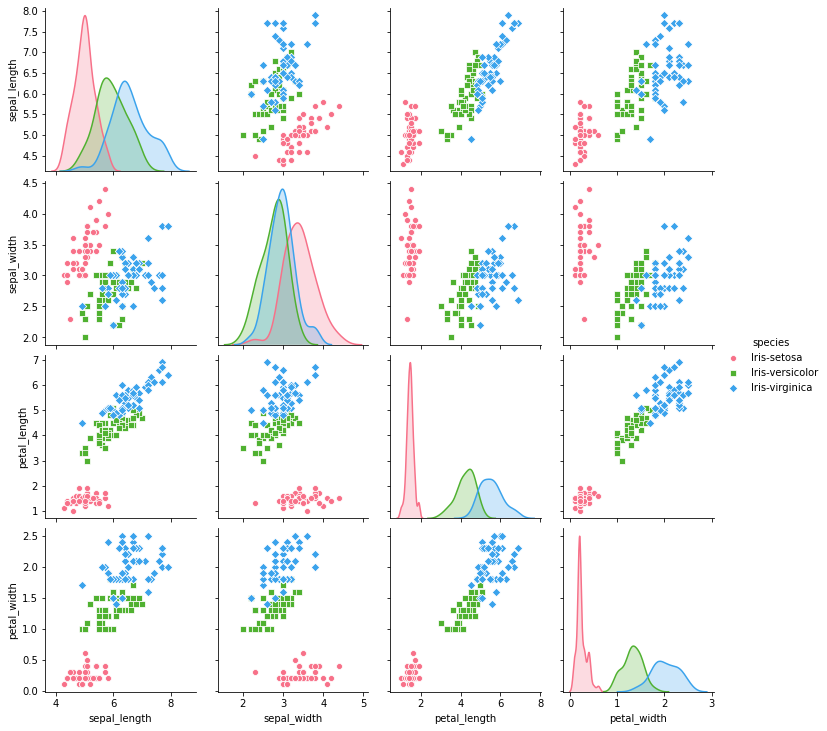

In [7]:
g = sns.pairplot(data, hue="species", palette="husl", markers=["o", "s", "D"])

Now we perform our MCMC computaiton.  With pymc3, this is very easy.  We use the usual "with" declaration for pymc3, then use glm for our logistic model and just have to specidfy the formula, the data, and the family.  The family is what tells pymc3 that this will be logistic regression.

We are going to use the default priors for GLM coefficients from PyMC3, which is $p(\theta)=N(0,10^{12}I)$.  These are very weak priors.

In [8]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'species ~ sepal_length + sepal_width + petal_length + petal_width', 
                            data = data, 
                            family = pm.glm.families.Binomial())

    trace = pm.sample(1000)

Sampling 2 chains, 86 divergences: 100%|██████████| 3000/3000 [00:35<00:00, 84.60draws/s] 


Here are the variable names in the output.  

In [9]:
trace.varnames

['Intercept', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']

Here is our nice custom traceplot using the function plot_traces we defined previously.

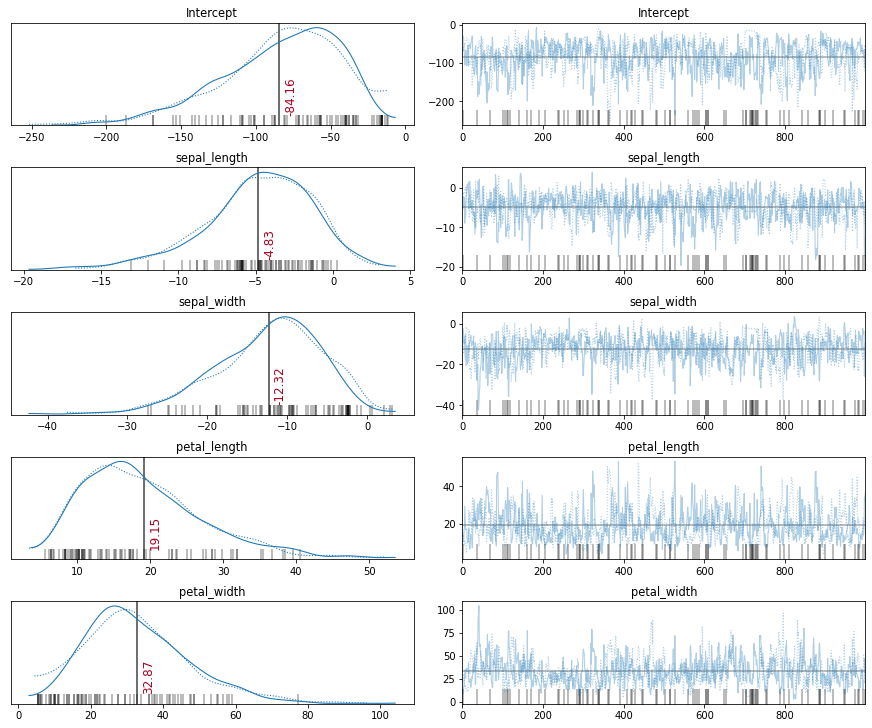

In [10]:
plot_traces(trace)

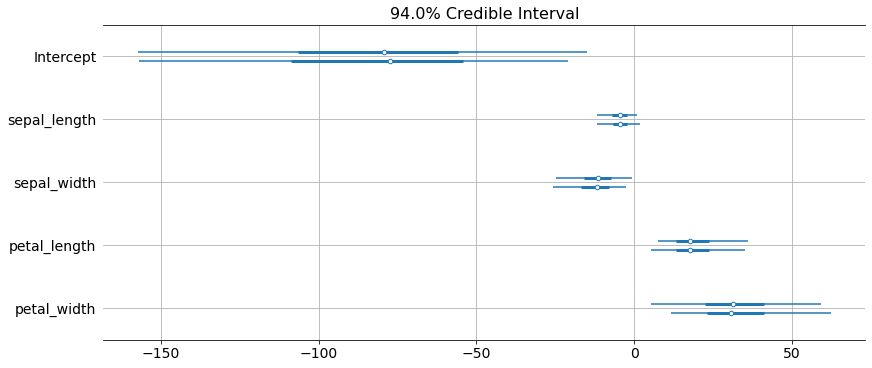

In [11]:
pm.plots.forestplot(trace, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

<Figure size 648x504 with 0 Axes>

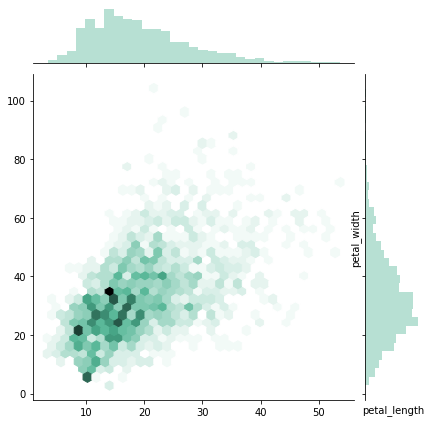

<Figure size 648x504 with 0 Axes>

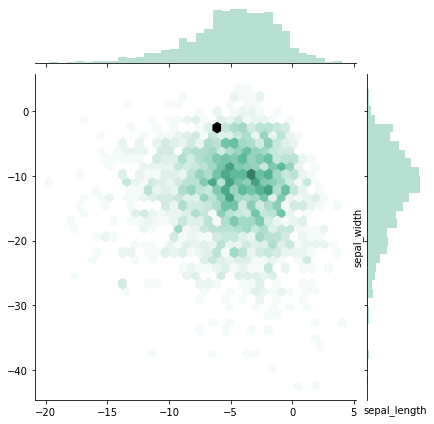

In [12]:
plt.figure(figsize=(9,7))
sns.jointplot(trace['petal_length'], trace['petal_width'], kind="hex", color="#4CB391")
plt.xlabel("petal_length")
plt.ylabel("petal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['sepal_width'], kind="hex", color="#4CB391")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");
plt.show()

Because the 94.0 percent credible interval for `sepal_length` contains 0 / substantial areas are on each side of 0 for the trace plot of `sepal_length` or the histogram corresponding to `sepal_length` in the joint plot, the coefficient for `sepal_length` might be zero. Because the coefficient for `sepal_length` might be zero, `sepal_length` might provide little or no predictive information.

Because the 94.0 percent credible interval for `sepal_width` is close to containing 0 / substantial areas are on each side of 0 for the trace plot of `sepal_width` or the histogram corresponding to `sepal_length` in the joint plot, the coefficient for `sepal_width` might be zero. Because the coefficient for `sepal_width` might be zero, `sepal_width` might provide little or no predictive information.

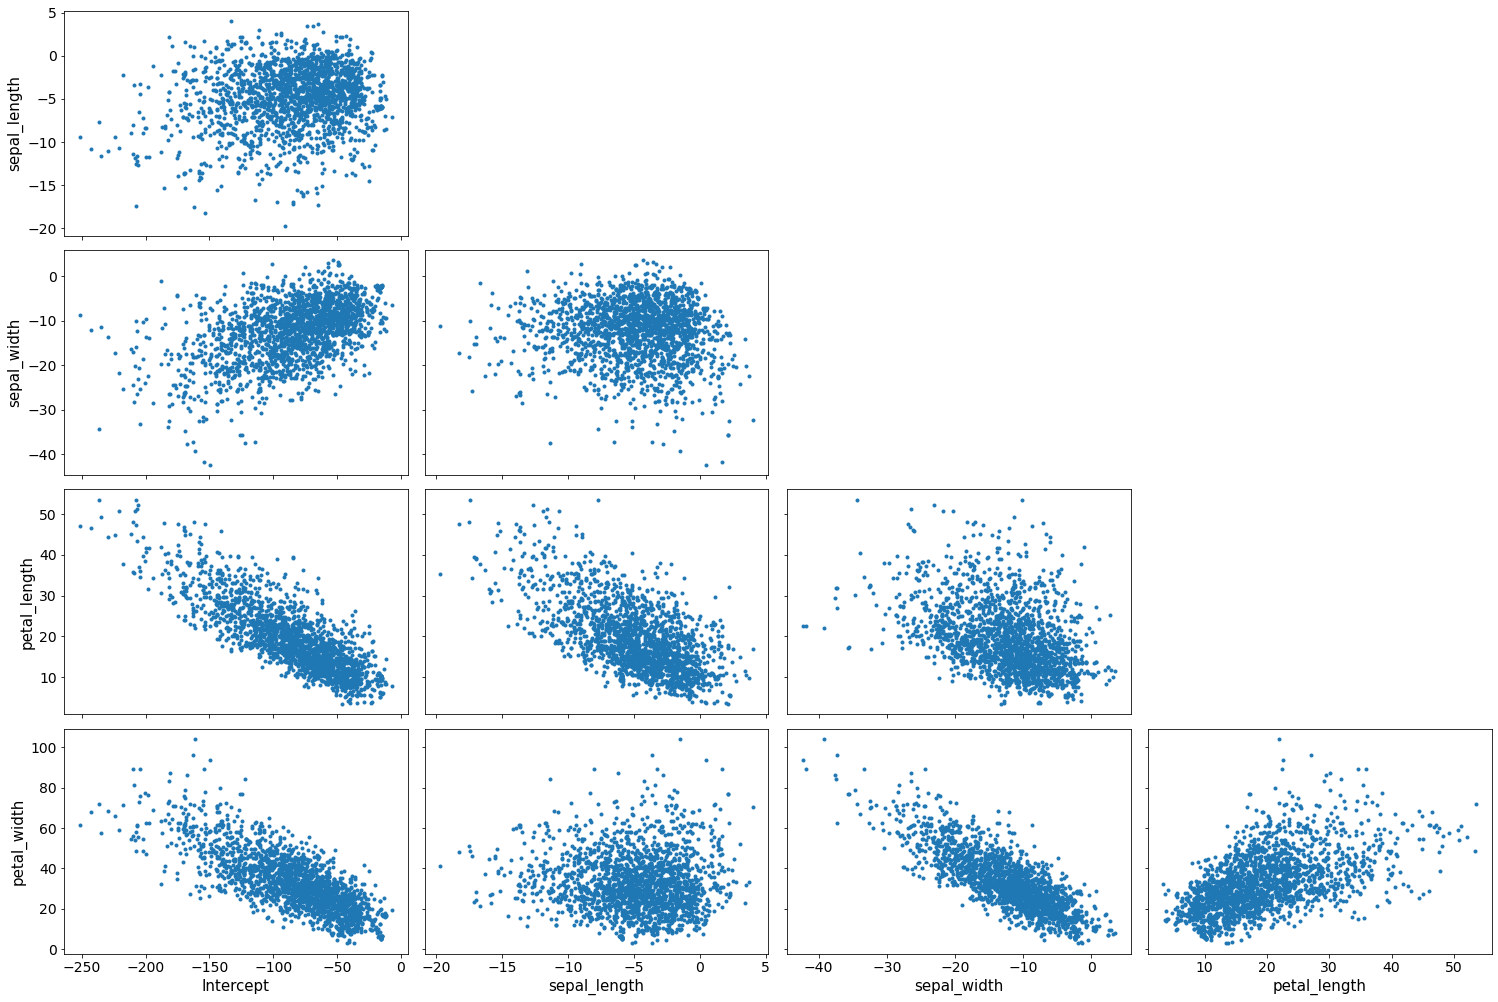

In [13]:
# Here are all pairs of variables in the scatterplot of the sampling.
import arviz as az
az.plot_pair(trace);

# Part 2. Logistic Regression for Predicting Coronary Heart Disease

Now lets apply some Bayesian Regression techniques to a healthcare problem of determining risk for Coronary Heart Disease.  Logistic Regression is a great method for this problem because it provides esitmates of probability of heart disease and the Bayesian analysis provides insight into uncertainty and importance of the different predicotr variables.

In [14]:
chd_data = pd.read_csv("../input/coronary-heart-disease/CHDdata.csv")
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [15]:
chd_data.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


In [16]:
# Standardize the data (mean for each numerical variable of zero, standard deviation of one.)
for key in chd_data.keys()[0:9]:
    try:
        print("Standardizing "+key+".")
        chd_data[key] = chd_data[key] - np.mean(chd_data[key])
        chd_data[key] = chd_data[key] / np.std(chd_data[key])
    except:
        print("Predictor "+key+" cannot be standardized (probably a categorical variable).")
chd_data.describe()

Standardizing sbp.
Standardizing tobacco.
Standardizing ldl.
Standardizing adiposity.
Standardizing famhist.
Predictor famhist cannot be standardized (probably a categorical variable).
Standardizing typea.
Standardizing obesity.
Standardizing alcohol.
Standardizing age.


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,462.000000
mean,-2.571296e-16,5.022437e-16,-3.963040e-15,1.559599e-15,1.153478e-17,-5.286776e-15,-4.169344e-16,1.970526e-17,0.346320
std,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,0.476313
min,-1.823123e+00,-7.924170e-01,-1.817753e+00,-2.401708e+00,-4.089354e+00,-2.695129e+00,-6.969825e-01,-1.906103e+00,0.000000
25%,-6.997535e-01,-7.809742e-01,-7.047170e-01,-7.245926e-01,-6.224081e-01,-7.267824e-01,-6.761275e-01,-8.096968e-01,0.000000
50%,-2.113321e-01,-3.565020e-01,-1.935182e-01,9.112757e-02,-1.059418e-02,-5.680824e-02,-3.898822e-01,1.496582e-01,0.000000
75%,4.724579e-01,4.063492e-01,5.074164e-01,7.489145e-01,7.031887e-01,5.828745e-01,2.800340e-01,8.349118e-01,1.000000
max,3.891408e+00,6.007857e+00,5.119082e+00,2.197976e+00,2.538631e+00,4.878906e+00,5.321938e+00,1.451640e+00,1.000000


In [17]:
# Lets check the mean of each class to get a first look at the seperation
print("Mean for CHD Positive:")
print(np.array([chd_data[chd_data.chd == 1].mean()]))
print(np.array([chd_data[chd_data.chd == 1].mean()[0:8]]))
print("Mean for CHD Negative:")
print(np.array([chd_data[chd_data.chd == 0].mean()[0:8]]))

Mean for CHD Positive:
[[0.26426823 0.41177089 0.36139839 0.34912802 0.14172199 0.13751694
  0.0859086  0.51241433 1.        ]]
[[0.26426823 0.41177089 0.36139839 0.34912802 0.14172199 0.13751694
  0.0859086  0.51241433]]
Mean for CHD Negative:
[[-0.14000966 -0.21815676 -0.19146935 -0.18496849 -0.0750845  -0.07285666
  -0.04551449 -0.27147779]]


In [18]:
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,Present,-0.418470,-0.176786,3.277738,0.629336,1
1,0.277089,-0.790237,-0.159680,0.412140,Absent,0.193344,0.671373,-0.612745,1.383115,1
2,-0.992806,-0.774980,-0.609245,0.884332,Present,-0.112563,0.735519,-0.541183,0.218184,0
3,1.546985,0.842264,0.807126,1.624141,Present,-0.214532,1.412621,0.295062,1.040488,1
4,-0.211332,2.171805,-0.599577,0.305351,Present,0.703189,-0.012856,1.647775,0.423760,1


In [19]:
chd_data['famhist'] = chd_data['famhist'] == 'Present'
chd_data['famhist'] = chd_data['famhist'].astype(int)
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,1,-0.418470,-0.176786,3.277738,0.629336,1
1,0.277089,-0.790237,-0.159680,0.412140,0,0.193344,0.671373,-0.612745,1.383115,1
2,-0.992806,-0.774980,-0.609245,0.884332,1,-0.112563,0.735519,-0.541183,0.218184,0
3,1.546985,0.842264,0.807126,1.624141,1,-0.214532,1.412621,0.295062,1.040488,1
4,-0.211332,2.171805,-0.599577,0.305351,1,0.703189,-0.012856,1.647775,0.423760,1


Now we can build our model in PYMC3 and examine the results:

In [20]:
with pm.Model() as multivariate_logistic_model:
    list_of_continuous_predictors = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
    number_of_continuous_predictors = len(list_of_continuous_predictors)
    mean_of_prior_probability_density_distribution_for_continuous_predictors = np.zeros(number_of_continuous_predictors)
    variance_covariance_matrix_of_prior_probability_density_distribution_for_continuous_predictors = np.eye(number_of_continuous_predictors)
    prior_probability_distribution_for_continuous_predictors = pm.MvNormal(
        'P(continuous_predictors)',
        mu = mean_of_prior_probability_density_distribution_for_continuous_predictors,
        cov = variance_covariance_matrix_of_prior_probability_density_distribution_for_continuous_predictors,
        shape = number_of_continuous_predictors
    )
    prior_probability_density_distribution_for_sbp = prior_probability_distribution_for_continuous_predictors[0]
    prior_probability_density_distribution_for_tobacco = prior_probability_distribution_for_continuous_predictors[1]
    prior_probability_density_distribution_for_ldl = prior_probability_distribution_for_continuous_predictors[2]
    prior_probability_density_distribution_for_adiposity = prior_probability_distribution_for_continuous_predictors[3]
    prior_probability_density_distribution_for_typea = prior_probability_distribution_for_continuous_predictors[4]
    prior_probability_density_distribution_for_obesity = prior_probability_distribution_for_continuous_predictors[5]
    prior_probability_density_distribution_for_alcohol = prior_probability_distribution_for_continuous_predictors[6]
    prior_probability_density_distribution_for_age = prior_probability_distribution_for_continuous_predictors[7]
    prior_probability_density_distribution_for_famhist = pm.Beta('famhist', alpha = 1, beta = 1)
    likelihood_and_sampling_probability_density_distribution_of_response_values_given_parameters = pm.invlogit(
        prior_probability_density_distribution_for_sbp * chd_data.sbp
        + prior_probability_density_distribution_for_tobacco * chd_data.tobacco
        + prior_probability_density_distribution_for_ldl * chd_data.ldl
        + prior_probability_density_distribution_for_adiposity * chd_data.adiposity
        + prior_probability_density_distribution_for_typea * chd_data.typea
        + prior_probability_density_distribution_for_obesity * chd_data.obesity
        + prior_probability_density_distribution_for_alcohol * chd_data.alcohol
        + prior_probability_density_distribution_for_age * chd_data.age
        + prior_probability_density_distribution_for_famhist * chd_data.famhist
    )
    likelihood_and_sampling_probability_density_distribution_of_response_values = pm.Bernoulli(
        name = 'logit',
        p = likelihood_and_sampling_probability_density_distribution_of_response_values_given_parameters,
        observed = chd_data.chd
    )
    trace = pm.sample(5000)

Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:22<00:00, 484.69draws/s]


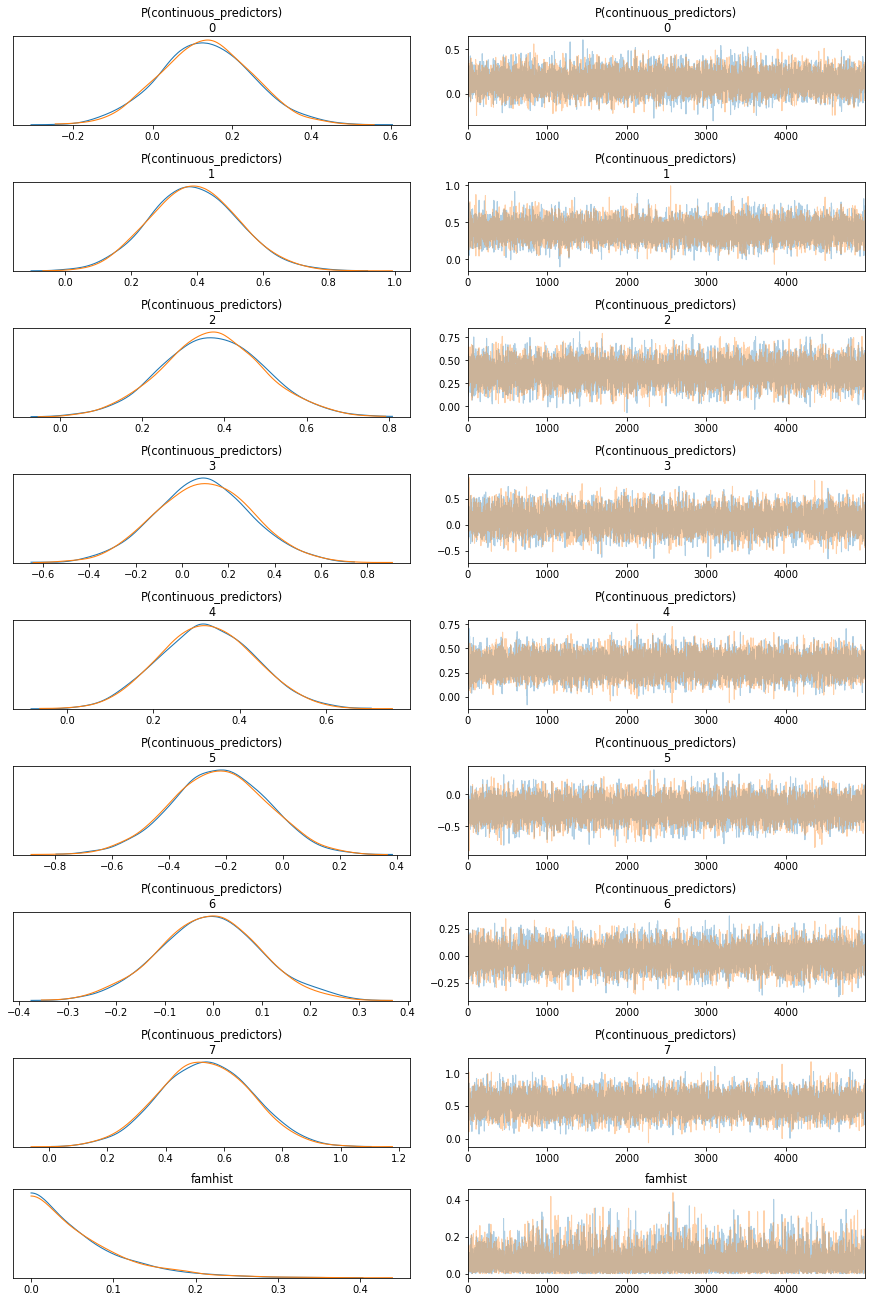

In [21]:
import arviz
arviz.plot_trace(trace)
plt.show()

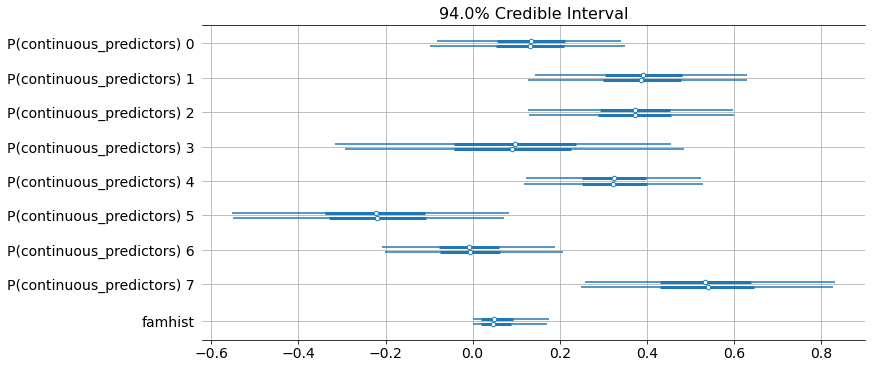

In [22]:
pm.plots.forestplot(trace, figsize=(12, 5))
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
plt.grid()  # add a grid to the plot

In [23]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P(continuous_predictors)[0],0.13,0.12,-0.10,0.34,0.0,0.0,14789.0,9158.0,14804.0,7864.0,1.0
P(continuous_predictors)[1],0.39,0.13,0.14,0.64,0.0,0.0,12533.0,11179.0,12575.0,7278.0,1.0
P(continuous_predictors)[2],0.37,0.12,0.13,0.60,0.0,0.0,16760.0,14153.0,16765.0,7598.0,1.0
P(continuous_predictors)[3],0.09,0.21,-0.30,0.48,0.0,0.0,7588.0,5764.0,7595.0,7647.0,1.0
P(continuous_predictors)[4],0.32,0.11,0.12,0.53,0.0,0.0,16217.0,14556.0,16218.0,7803.0,1.0
P(continuous_predictors)[5],-0.22,0.17,-0.55,0.08,0.0,0.0,8853.0,7760.0,8870.0,7997.0,1.0
P(continuous_predictors)[6],-0.01,0.10,-0.21,0.20,0.0,0.0,15758.0,4522.0,15742.0,7543.0,1.0
P(continuous_predictors)[7],0.54,0.16,0.25,0.83,0.0,0.0,10174.0,9777.0,10177.0,7969.0,1.0
famhist,0.06,0.06,0.00,0.17,0.0,0.0,13957.0,10895.0,9801.0,4878.0,1.0


# For another example incorporating priors, see: https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a

In [24]:
# we will use this to get a -1 or 1 from the famhist
observed_indicators_of_CHD = 1-2*(chd_data['chd']!=1)
observed_indicators_of_CHD

0      1
1      1
2     -1
3      1
4      1
      ..
457   -1
458    1
459   -1
460   -1
461    1
Name: chd, Length: 462, dtype: int64

In [25]:
with multivariate_logistic_model:
    array_of_predicted_response_values = pm.sample_posterior_predictive(trace)['logit']
one_dimensional_array_of_averages_of_predicted_response_values = array_of_predicted_response_values.mean(axis = 0)
one_dimensional_array_of_averages_of_predicted_response_values

100%|██████████| 10000/10000 [00:10<00:00, 916.21it/s]


array([0.7793, 0.5932, 0.3523, 0.7747, 0.7532, 0.682 , 0.5035, 0.682 ,
       0.2394, 0.6644, 0.8256, 0.7885, 0.1608, 0.1218, 0.6011, 0.2531,
       0.9166, 0.9024, 0.8116, 0.7906, 0.2839, 0.501 , 0.7035, 0.5195,
       0.8424, 0.8184, 0.6865, 0.858 , 0.7093, 0.7122, 0.5064, 0.7118,
       0.7125, 0.5784, 0.6725, 0.4129, 0.4538, 0.4112, 0.3541, 0.8989,
       0.4679, 0.1599, 0.0984, 0.4395, 0.0746, 0.5944, 0.8884, 0.4269,
       0.1484, 0.3252, 0.3748, 0.4686, 0.6535, 0.3918, 0.5669, 0.6957,
       0.196 , 0.4089, 0.1579, 0.5916, 0.276 , 0.5688, 0.8348, 0.2725,
       0.161 , 0.6539, 0.2651, 0.1198, 0.4638, 0.3881, 0.184 , 0.3889,
       0.4489, 0.285 , 0.4637, 0.3906, 0.5203, 0.6421, 0.7113, 0.4467,
       0.6314, 0.4843, 0.7981, 0.7931, 0.238 , 0.3493, 0.794 , 0.2976,
       0.5143, 0.34  , 0.152 , 0.6717, 0.2637, 0.495 , 0.6659, 0.7167,
       0.2709, 0.3646, 0.8125, 0.6393, 0.7922, 0.2968, 0.3457, 0.1927,
       0.3889, 0.7101, 0.689 , 0.5801, 0.5449, 0.1674, 0.3895, 0.9041,
      

In [26]:
print(len(one_dimensional_array_of_averages_of_predicted_response_values))

462


In [27]:
predicted_indicators_of_CHD = [1 if i > 0.5 else -1 for i in one_dimensional_array_of_averages_of_predicted_response_values]
predicted_indicators_of_CHD[0:5]

[1, 1, -1, 1, 1]

In [28]:
number_of_observations_for_which_prediction_was_correct = 0
number_of_observations = len(observed_indicators_of_CHD)
for i in range(0, number_of_observations):
    if predicted_indicators_of_CHD[i] == observed_indicators_of_CHD[i]:
        number_of_observations_for_which_prediction_was_correct += 1
accuracy = number_of_observations_for_which_prediction_was_correct / number_of_observations
accuracy

0.6753246753246753

In "Bayesian Model Averaging Logistic Regression", the probability that predictor alcohol appears in best models is 0. In "PyMC3 Bayesian Logistic Regression Classification", the posterior probability density distribution for the probability that predictor alcohol appears in best models given data is centered around 0. In the former, the probability that predictor adiposity appears in best models is slightly more than 0. In the latter, the posterior probability density distribution for the probability that predictor adiposity appears in best models given data is centered around a number slightly more than 0.

The accuracy of our PyMC logistic-regression classifier is slightly more than that of our unregularized classical logistic-regression classifier and slightly less than that of our regularized classical logistic-regression model. The accuracy of our PyMC logistic-regression classifier is slightly less than that of our BMA model.